**PHASE 0: Environment Setup**

In [7]:
# Install required packages
!pip install transformers datasets torch scikit-learn accelerate seaborn matplotlib pandas numpy
!pip install torchcrf  # For CRF layer (slot filling)

# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    cohen_kappa_score
)
import warnings
warnings.filterwarnings('ignore')

print("✓ All packages installed successfully!")


GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
✓ All packages installed successfully!


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PHASE 1: Data Loading and Exploration**

In [9]:
# STEP 1.1: Load MASSIVE Dataset from Google Drive

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted!")

# Define the path to your MASSIVE dataset
# Update this path based on where you saved the dataset in your Drive
DATASET_PATH = "/content/drive/MyDrive/intent_project/data"  # Adjust this path!

# Check if the path exists
import os
if os.path.exists(DATASET_PATH):
    print(f"✓ Dataset path found: {DATASET_PATH}")
    # List files in the directory
    files = os.listdir(DATASET_PATH)
    print(f"\nFiles in dataset directory: {files[:10]}")  # Show first 10 files
else:
    print(f"✗ Dataset path not found: {DATASET_PATH}")
    print("Please update DATASET_PATH to match your Google Drive structure")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted!
✓ Dataset path found: /content/drive/MyDrive/intent_project/data

Files in dataset directory: ['af-ZA.jsonl', 'am-ET.jsonl', 'ar-SA.jsonl', 'az-AZ.jsonl', 'bn-BD.jsonl', 'cy-GB.jsonl', 'da-DK.jsonl', 'de-DE.jsonl', 'el-GR.jsonl', 'es-ES.jsonl']


In [10]:
# Load MASSIVE dataset from JSON files
import json
import pandas as pd
from datasets import Dataset, DatasetDict

# CORRECTED Function - Properly splits by partition field

def load_massive_from_json(data_path, lang_code):
    """
    Load MASSIVE data for a specific language and split by partition field
    """
    # Try different possible file naming patterns
    possible_files = [
        f"{lang_code}.jsonl",
        f"{lang_code}.json",
        f"{lang_code.lower()}.jsonl",
    ]

    json_file = None
    for filename in possible_files:
        filepath = os.path.join(data_path, filename)
        if os.path.exists(filepath):
            json_file = filepath
            break

    if not json_file:
        raise FileNotFoundError(f"Could not find data file for {lang_code}")

    # Load all data from the file
    with open(json_file, 'r', encoding='utf-8') as f:
        all_data = [json.loads(line) for line in f]

    # Convert to DataFrame for easier filtering
    df = pd.DataFrame(all_data)

    # IMPORTANT: Split by the 'partition' column
    train_df = df[df['partition'] == 'train'].reset_index(drop=True)
    dev_df = df[df['partition'] == 'dev'].reset_index(drop=True)
    test_df = df[df['partition'] == 'test'].reset_index(drop=True)

    # Create HuggingFace Dataset objects
    splits = {
        'train': Dataset.from_pandas(train_df),
        'validation': Dataset.from_pandas(dev_df),  # Note: using 'validation' not 'dev'
        'test': Dataset.from_pandas(test_df)
    }

    return DatasetDict(splits)


# Example: Load English dataset
test_dataset = load_massive_from_json(DATASET_PATH, 'en-US')
print("English Dataset:")
print(test_dataset)
print(f"\nTrain samples: {len(test_dataset['train']):,}")
print(f"Validation samples: {len(test_dataset['validation']):,}")
print(f"Test samples: {len(test_dataset['test']):,}")
print(f"Total: {len(test_dataset['train']) + len(test_dataset['validation']) + len(test_dataset['test']):,}")

# Verify partitions are correct
print("\n=== Verifying Partition Field ===")
print("Train partition values:", test_dataset['train']['partition'][:5])
print("Validation partition values:", test_dataset['validation']['partition'][:5])
print("Test partition values:", test_dataset['test']['partition'][:5])

English Dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id'],
        num_rows: 2974
    })
})

Train samples: 11,514
Validation samples: 2,033
Test samples: 2,974
Total: 16,521

=== Verifying Partition Field ===
Train partition values: ['train', 'train', 'train', 'train', 'train']
Validation partition values: ['dev', 'dev', 'dev', 'dev', 'dev']
Test partition values: ['test', 'test', 'test', 'test', 'test']


In [11]:
# Step 1.2: Load All Phase 1 Languages from Google Drive

PHASE_1_LANGUAGES = [
    'en-US',  # English
    'es-ES',  # Spanish
    'fr-FR',  # French
    'de-DE',  # German
    'zh-CN',  # Mandarin Chinese
    'ja-JP',  # Japanese
    'ar-SA',  # Arabic
    'hi-IN',  # Hindi
    'bn-BD',  # Bengali
    'id-ID',  # Indonesian
    'th-TH',  # Thai
    'pt-PT',  # Portuguese
    'it-IT',  # Italian
    'nl-NL',  # Dutch
    'ru-RU',  # Russian
    'vi-VN',  # Vietnamese
    'ko-KR',  # Korean
    'tr-TR',  # Turkish
    'pl-PL',  # Polish
    'sv-SE',  # Swedish
]

multilingual_datasets = {}

print(f"Loading {len(PHASE_1_LANGUAGES)} languages from Google Drive...\n")

for lang in PHASE_1_LANGUAGES:
    try:
        ds = load_massive_from_json(DATASET_PATH, lang)
        multilingual_datasets[lang] = ds
        print(f"✓ Loaded {lang}: {len(ds['train'])} train, {len(ds['validation'])} val, {len(ds['test'])} test")
    except Exception as e:
        print(f"✗ Error loading {lang}: {e}")

print(f"\n✓ Successfully loaded {len(multilingual_datasets)} languages!")
print(f"Total training samples: {sum(len(ds['train']) for ds in multilingual_datasets.values()):,}")


Loading 20 languages from Google Drive...

✓ Loaded en-US: 11514 train, 2033 val, 2974 test
✓ Loaded es-ES: 11514 train, 2033 val, 2974 test
✓ Loaded fr-FR: 11514 train, 2033 val, 2974 test
✓ Loaded de-DE: 11514 train, 2033 val, 2974 test
✓ Loaded zh-CN: 11514 train, 2033 val, 2974 test
✓ Loaded ja-JP: 11514 train, 2033 val, 2974 test
✓ Loaded ar-SA: 11514 train, 2033 val, 2974 test
✓ Loaded hi-IN: 11514 train, 2033 val, 2974 test
✓ Loaded bn-BD: 11514 train, 2033 val, 2974 test
✓ Loaded id-ID: 11514 train, 2033 val, 2974 test
✓ Loaded th-TH: 11514 train, 2033 val, 2974 test
✓ Loaded pt-PT: 11514 train, 2033 val, 2974 test
✓ Loaded it-IT: 11514 train, 2033 val, 2974 test
✓ Loaded nl-NL: 11514 train, 2033 val, 2974 test
✓ Loaded ru-RU: 11514 train, 2033 val, 2974 test
✓ Loaded vi-VN: 11514 train, 2033 val, 2974 test
✓ Loaded ko-KR: 11514 train, 2033 val, 2974 test
✓ Loaded tr-TR: 11514 train, 2033 val, 2974 test
✓ Loaded pl-PL: 11514 train, 2033 val, 2974 test
✓ Loaded sv-SE: 11514 trai

In [12]:
# STEP 1.3: Combine All Languages into Multilingual Dataset

from datasets import concatenate_datasets

print("Combining all Phase 1 language datasets...\n")

train_datasets = []
validation_datasets = []
test_datasets = []

for lang, ds in multilingual_datasets.items():
    train_datasets.append(ds['train'])
    validation_datasets.append(ds['validation'])
    test_datasets.append(ds['test'])

# Concatenate all datasets
combined_train = concatenate_datasets(train_datasets)
combined_val = concatenate_datasets(validation_datasets)
combined_test = concatenate_datasets(test_datasets)

# Create final dataset dictionary
final_dataset = DatasetDict({
    'train': combined_train,
    'validation': combined_val,
    'test': combined_test
})

print("="*70)
print("=== COMBINED MULTILINGUAL DATASET ===")
print("="*70)
print(f"Training samples: {len(final_dataset['train']):,}")
print(f"Validation samples: {len(final_dataset['validation']):,}")
print(f"Test samples: {len(final_dataset['test']):,}")
print(f"Grand Total: {len(final_dataset['train']) + len(final_dataset['validation']) + len(final_dataset['test']):,}")

print(f"\nDataset features:")
for feature, dtype in final_dataset['train'].features.items():
    print(f"  - {feature}: {dtype}")

print(f"\n=== Sample from Combined Dataset ===")
print(final_dataset['train'][0])


Combining all Phase 1 language datasets...

=== COMBINED MULTILINGUAL DATASET ===
Training samples: 230,280
Validation samples: 40,660
Test samples: 59,480
Grand Total: 330,420

Dataset features:
  - id: Value('string')
  - locale: Value('string')
  - partition: Value('string')
  - scenario: Value('string')
  - intent: Value('string')
  - utt: Value('string')
  - annot_utt: Value('string')
  - worker_id: Value('string')
  - slot_method: List({'method': Value('string'), 'slot': Value('string')})
  - judgments: List({'grammar_score': Value('int64'), 'intent_score': Value('int64'), 'language_identification': Value('string'), 'slots_score': Value('int64'), 'spelling_score': Value('int64'), 'worker_id': Value('string')})

=== Sample from Combined Dataset ===
{'id': '1', 'locale': 'en-US', 'partition': 'train', 'scenario': 'alarm', 'intent': 'alarm_set', 'utt': 'wake me up at nine am on friday', 'annot_utt': 'wake me up at [time : nine am] on [date : friday]', 'worker_id': '1', 'slot_method'

**SAVING TRAIN,TEST,VAL FOLDERS TO DRIVE**

In [13]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define base save path
base_dir = "/content/drive/MyDrive/intent_project"
os.makedirs(base_dir, exist_ok=True)

# Save each split in its own folder
final_dataset['train'].save_to_disk(os.path.join(base_dir, "train"))
final_dataset['validation'].save_to_disk(os.path.join(base_dir, "validation"))
final_dataset['test'].save_to_disk(os.path.join(base_dir, "test"))

print("✅ Saved successfully!")
print(f"Train folder: {base_dir}/train")
print(f"Validation folder: {base_dir}/validation")
print(f"Test folder: {base_dir}/test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/230280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/40660 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59480 [00:00<?, ? examples/s]

✅ Saved successfully!
Train folder: /content/drive/MyDrive/intent_project/train
Validation folder: /content/drive/MyDrive/intent_project/validation
Test folder: /content/drive/MyDrive/intent_project/test


In [14]:
from datasets import load_from_disk

train_dataset = load_from_disk("/content/drive/MyDrive/intent_project/train")
val_dataset = load_from_disk("/content/drive/MyDrive/intent_project/validation")
test_dataset = load_from_disk("/content/drive/MyDrive/intent_project/test")

print(len(train_dataset), len(val_dataset), len(test_dataset))

230280 40660 59480



=== DATASET OVERVIEW ===
Total training samples: 230,280
Features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments']

Data shape: (230280, 10)

=== INTENT DISTRIBUTION ===
Total unique intents: 60

Top 15 most frequent intents:
intent
calendar_set       16200
play_music         12780
weather_query      11460
calendar_query     11320
general_quirky     11100
qa_factoid         10880
news_query         10060
email_query         8360
email_sendemail     7080
datetime_query      7000
calendar_remove     6240
social_post         5660
play_radio          5660
qa_definition       5340
transport_query     4540
Name: count, dtype: int64

Bottom 5 least frequent intents:
intent
general_greet         500
iot_hue_lighton       440
audio_volume_other    360
music_dislikeness     280
cooking_query          80
Name: count, dtype: int64


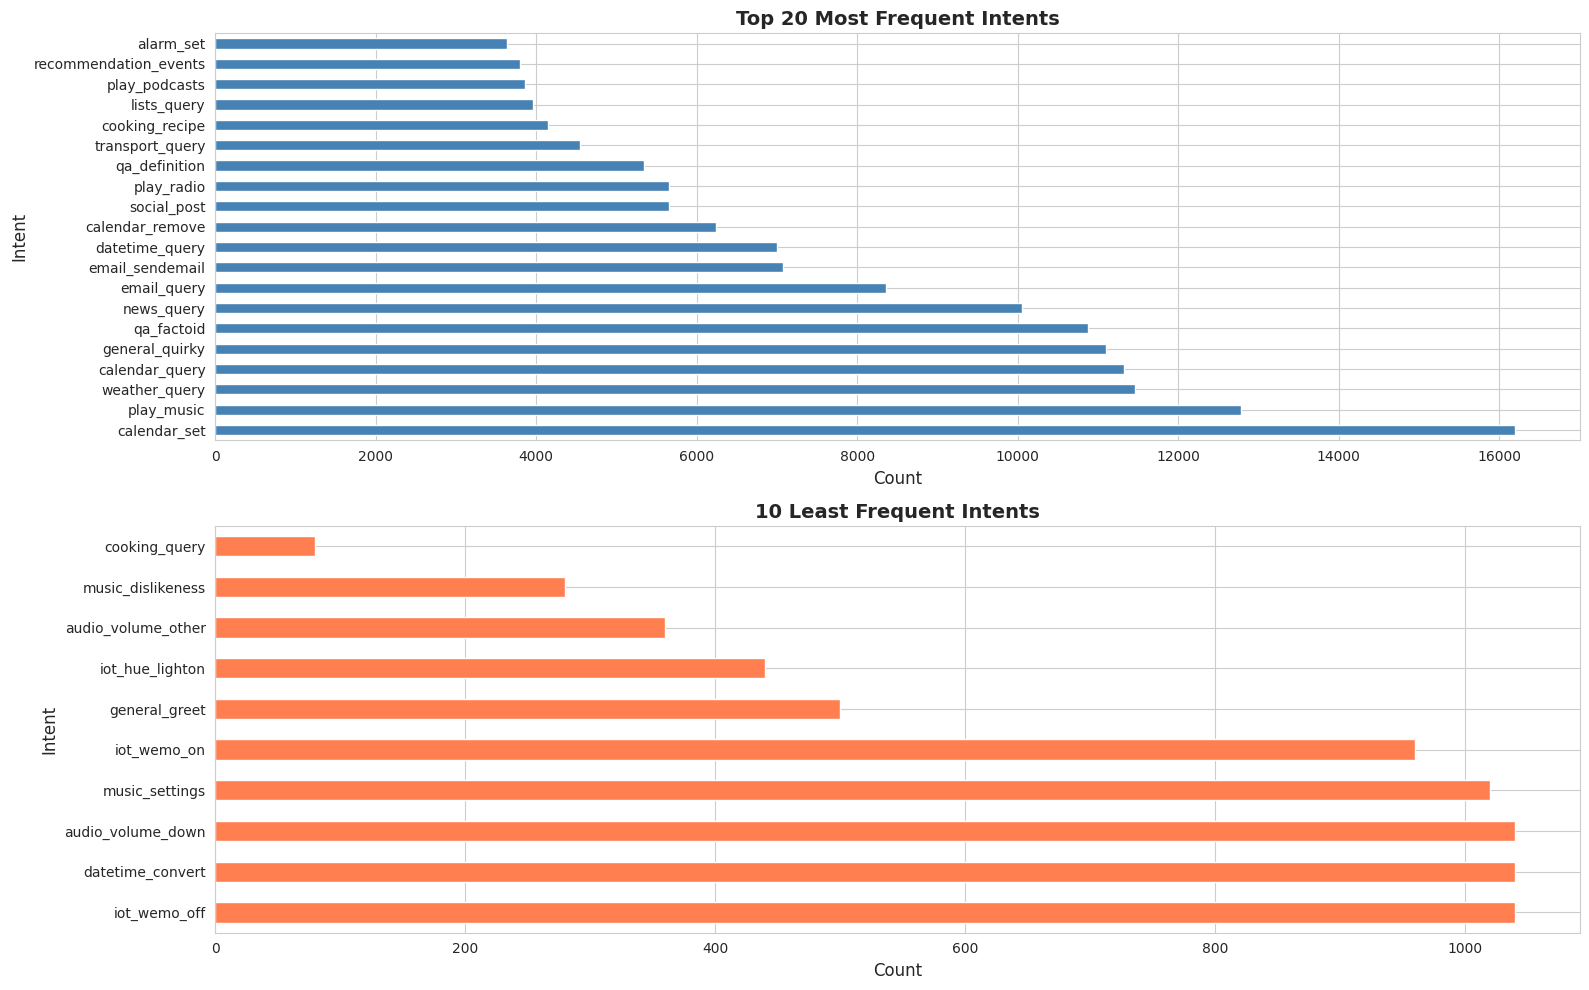

✓ Intent distribution plot saved!

=== CLASS IMBALANCE ANALYSIS ===
Most frequent intent: calendar_set → 16,200 samples
Least frequent intent: cooking_query → 80 samples
Imbalance ratio: 202.50:1

=== LANGUAGE DISTRIBUTION ===
  ar-SA: 11,514 samples
  bn-BD: 11,514 samples
  de-DE: 11,514 samples
  en-US: 11,514 samples
  es-ES: 11,514 samples
  fr-FR: 11,514 samples
  hi-IN: 11,514 samples
  id-ID: 11,514 samples
  it-IT: 11,514 samples
  ja-JP: 11,514 samples
  ko-KR: 11,514 samples
  nl-NL: 11,514 samples
  pl-PL: 11,514 samples
  pt-PT: 11,514 samples
  ru-RU: 11,514 samples
  sv-SE: 11,514 samples
  th-TH: 11,514 samples
  tr-TR: 11,514 samples
  vi-VN: 11,514 samples
  zh-CN: 11,514 samples

=== SCENARIO DISTRIBUTION ===
  calendar: 33,760 samples
  play: 27,540 samples
  qa: 23,660 samples
  email: 19,060 samples
  iot: 15,380 samples
  general: 13,040 samples
  weather: 11,460 samples
  transport: 11,420 samples
  lists: 10,780 samples
  news: 10,060 samples
  recommendation: 

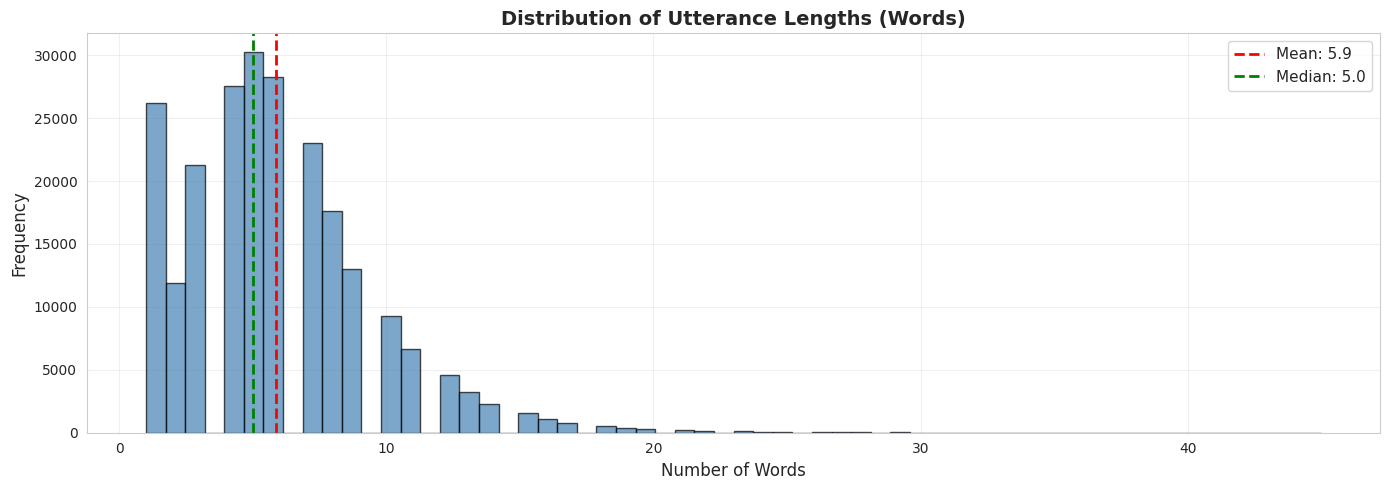

✓ Utterance length plot saved!

=== SUMMARY STATISTICS ===
Shortest utterance: 1 words
Longest utterance: 45 words
Mean utterance length: 5.9 words
Median utterance length: 5.0 words
Std dev: 3.6 words
95th percentile: 12 words


In [15]:
# STEP 1.4: Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Convert training data to DataFrame for analysis
train_df = pd.DataFrame(final_dataset['train'])

print("\n" + "="*70)
print("=== DATASET OVERVIEW ===")
print("="*70)
print(f"Total training samples: {len(train_df):,}")
print(f"Features: {train_df.columns.tolist()}")
print(f"\nData shape: {train_df.shape}")

# Analyze intent distribution
print("\n" + "="*70)
print("=== INTENT DISTRIBUTION ===")
print("="*70)

intent_counts = train_df['intent'].value_counts()
print(f"Total unique intents: {len(intent_counts)}")
print(f"\nTop 15 most frequent intents:")
print(intent_counts.head(15))

print(f"\nBottom 5 least frequent intents:")
print(intent_counts.tail(5))

# Visualize intent distribution (top 20)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top 20 intents
ax1 = axes[0]
intent_counts.head(20).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('Top 20 Most Frequent Intents', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Intent', fontsize=12)

# Bottom 10 intents
ax2 = axes[1]
intent_counts.tail(10).plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('10 Least Frequent Intents', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Intent', fontsize=12)

plt.tight_layout()
plt.savefig('intent_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Intent distribution plot saved!")

# Class imbalance analysis
print("\n" + "="*70)
print("=== CLASS IMBALANCE ANALYSIS ===")
print("="*70)
print(f"Most frequent intent: {intent_counts.index[0]} → {intent_counts.iloc[0]:,} samples")
print(f"Least frequent intent: {intent_counts.index[-1]} → {intent_counts.iloc[-1]:,} samples")
imbalance_ratio = intent_counts.iloc[0] / intent_counts.iloc[-1]
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Language distribution
print("\n" + "="*70)
print("=== LANGUAGE DISTRIBUTION ===")
print("="*70)
locale_counts = train_df['locale'].value_counts().sort_index()
for locale, count in locale_counts.items():
    print(f"  {locale}: {count:,} samples")

# Scenario distribution
print("\n" + "="*70)
print("=== SCENARIO DISTRIBUTION ===")
print("="*70)
scenario_counts = train_df['scenario'].value_counts()
for scenario, count in scenario_counts.items():
    print(f"  {scenario}: {count:,} samples")

# Utterance length analysis
print("\n" + "="*70)
print("=== UTTERANCE LENGTH ANALYSIS ===")
print("="*70)
train_df['utt_length'] = train_df['utt'].str.split().str.len()

print(train_df['utt_length'].describe())

# Plot utterance length distribution
fig, ax = plt.subplots(figsize=(14, 5))
ax.hist(train_df['utt_length'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(train_df['utt_length'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {train_df['utt_length'].mean():.1f}")
ax.axvline(train_df['utt_length'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {train_df['utt_length'].median():.1f}")
ax.set_title('Distribution of Utterance Lengths (Words)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Words', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('utterance_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Utterance length plot saved!")

# Summary statistics
print("\n" + "="*70)
print("=== SUMMARY STATISTICS ===")
print("="*70)
print(f"Shortest utterance: {train_df['utt_length'].min()} words")
print(f"Longest utterance: {train_df['utt_length'].max()} words")
print(f"Mean utterance length: {train_df['utt_length'].mean():.1f} words")
print(f"Median utterance length: {train_df['utt_length'].median():.1f} words")
print(f"Std dev: {train_df['utt_length'].std():.1f} words")

# 95th percentile for tokenization length planning
percentile_95 = train_df['utt_length'].quantile(0.95)
print(f"95th percentile: {percentile_95:.0f} words")


In [16]:
# STEP 1.5: Create Intent Label Mappings

import json

# Get unique intents and create bidirectional mappings
unique_intents = sorted(train_df['intent'].unique())
intent2id = {intent: idx for idx, intent in enumerate(unique_intents)}
id2intent = {idx: intent for intent, idx in intent2id.items()}

print("\n" + "="*70)
print("=== INTENT LABEL MAPPINGS ===")
print("="*70)
print(f"Total unique intents: {len(unique_intents)}")
print(f"\nAll intents:")
for idx, intent in enumerate(unique_intents):
    print(f"  {idx:2d}: {intent}")

# Save mappings to files
with open('intent2id.json', 'w') as f:
    json.dump(intent2id, f, indent=2)

with open('id2intent.json', 'w') as f:
    json.dump(id2intent, f, indent=2)

print("\n✓ Intent mappings saved to:")
print("  - intent2id.json")
print("  - id2intent.json")

# Also save to Google Drive for persistence
drive_save_path = "/content/drive/MyDrive/intent_project"
os.makedirs(drive_save_path, exist_ok=True)

with open(f'{drive_save_path}/intent2id.json', 'w') as f:
    json.dump(intent2id, f, indent=2)

with open(f'{drive_save_path}/id2intent.json', 'w') as f:
    json.dump(id2intent, f, indent=2)

print(f"✓ Mappings also saved to Google Drive: {drive_save_path}")



=== INTENT LABEL MAPPINGS ===
Total unique intents: 60

All intents:
   0: alarm_query
   1: alarm_remove
   2: alarm_set
   3: audio_volume_down
   4: audio_volume_mute
   5: audio_volume_other
   6: audio_volume_up
   7: calendar_query
   8: calendar_remove
   9: calendar_set
  10: cooking_query
  11: cooking_recipe
  12: datetime_convert
  13: datetime_query
  14: email_addcontact
  15: email_query
  16: email_querycontact
  17: email_sendemail
  18: general_greet
  19: general_joke
  20: general_quirky
  21: iot_cleaning
  22: iot_coffee
  23: iot_hue_lightchange
  24: iot_hue_lightdim
  25: iot_hue_lightoff
  26: iot_hue_lighton
  27: iot_hue_lightup
  28: iot_wemo_off
  29: iot_wemo_on
  30: lists_createoradd
  31: lists_query
  32: lists_remove
  33: music_dislikeness
  34: music_likeness
  35: music_query
  36: music_settings
  37: news_query
  38: play_audiobook
  39: play_game
  40: play_music
  41: play_podcasts
  42: play_radio
  43: qa_currency
  44: qa_definition
  45: q

In [17]:
# STEP 1.6: Analyze Slot Filling Tags (for reference - Team Member 2)

print("\n" + "="*70)
print("=== SLOT FILLING ANALYSIS ===")
print("="*70)

# Check annotated utterances
print("\nSample annotated utterances (with slot annotations):")
for i in range(5):
    print(f"\n{i+1}. Original: {final_dataset['train'][i]['utt']}")
    print(f"   Annotated: {final_dataset['train'][i]['annot_utt']}")

# Parse slot types from annotated utterances
import re

def extract_slot_types(annot_utt):
    """Extract slot type tags from annotated utterance"""
    slots = re.findall(r'\[(\w+)\s*:', annot_utt)
    return slots

# Extract all unique slots
all_slots = set()
for annot in train_df['annot_utt'][:1000]:  # Sample 1000 to see patterns
    slots = extract_slot_types(str(annot))
    all_slots.update(slots)

print(f"\nUnique slot types found: {sorted(all_slots)}")
print(f"Total unique slots: {len(all_slots)}")



=== SLOT FILLING ANALYSIS ===

Sample annotated utterances (with slot annotations):

1. Original: wake me up at nine am on friday
   Annotated: wake me up at [time : nine am] on [date : friday]

2. Original: set an alarm for two hours from now
   Annotated: set an alarm for [time : two hours from now]

3. Original: olly quiet
   Annotated: olly quiet

4. Original: stop
   Annotated: stop

5. Original: olly pause for ten seconds
   Annotated: olly pause for [time : ten seconds]

Unique slot types found: ['alarm_type', 'app_name', 'artist_name', 'business_name', 'business_type', 'change_amount', 'coffee_type', 'color_type', 'date', 'device_type', 'event_name', 'food_type', 'general_frequency', 'house_place', 'joke_type', 'meal_type', 'media_type', 'music_descriptor', 'music_genre', 'news_topic', 'order_type', 'person', 'place_name', 'player_setting', 'playlist_name', 'song_name', 'time', 'time_zone', 'timeofday', 'weather_descriptor']
Total unique slots: 30


**PHASE 2: Tokenization**

In [18]:
# PHASE 2: Load XLM-RoBERTa Tokenizer

from transformers import AutoTokenizer

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("="*70)
print("=== XLM-RoBERTa TOKENIZER LOADED ===")
print("="*70)
print(f"Model: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size:,}")
print(f"Model max length: {tokenizer.model_max_length}")

# Test tokenization on a sample
sample_text = final_dataset['train'][0]['utt']
sample_intent = final_dataset['train'][0]['intent']

print(f"\n=== Tokenization Example ===")
print(f"Original utterance: {sample_text}")
print(f"Intent: {sample_intent}")

# Tokenize
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"\nTokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of tokens: {len(tokens)}")

# Full encoding with special tokens
encoded = tokenizer(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=128
)

print(f"\n=== Full Encoding ===")
print(f"input_ids length: {len(encoded['input_ids'])}")
print(f"attention_mask length: {len(encoded['attention_mask'])}")
print(f"input_ids (first 20): {encoded['input_ids'][:20]}")
print(f"attention_mask (first 20): {encoded['attention_mask'][:20]}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

=== XLM-RoBERTa TOKENIZER LOADED ===
Model: xlm-roberta-base
Vocab size: 250,002
Model max length: 512

=== Tokenization Example ===
Original utterance: wake me up at nine am on friday
Intent: alarm_set

Tokens: ['▁wake', '▁me', '▁up', '▁at', '▁ni', 'ne', '▁am', '▁on', '▁fri', 'day']
Token IDs: [9908, 163, 1257, 99, 300, 86, 444, 98, 5129, 5636]
Number of tokens: 10

=== Full Encoding ===
input_ids length: 128
attention_mask length: 128
input_ids (first 20): [0, 9908, 163, 1257, 99, 300, 86, 444, 98, 5129, 5636, 2, 1, 1, 1, 1, 1, 1, 1, 1]
attention_mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
# STEP 2.2: Tokenize the entire multilingual dataset

def preprocess_function_intent(examples):
    """
    Tokenize utterances and convert intent labels to IDs
    """
    # Tokenize the utterances
    tokenized = tokenizer(
        examples['utt'],
        padding='max_length',
        truncation=True,
        max_length=128,  # Based on EDA (95th percentile ~15 words)
        return_tensors=None
    )

    # Convert intent labels to IDs
    tokenized['labels'] = [intent2id[intent] for intent in examples['intent']]

    return tokenized

print("\n" + "="*70)
print("=== TOKENIZING ENTIRE DATASET ===")
print("="*70)
print("This may take 5-10 minutes for 330k samples...\n")

# Apply preprocessing to all splits
tokenized_dataset = final_dataset.map(
    preprocess_function_intent,
    batched=True,
    batch_size=100,
    remove_columns=final_dataset['train'].column_names,
    desc="Tokenizing dataset"
)

print("\n✓ Tokenization complete!")
print("\n=== TOKENIZED DATASET ===")
print(tokenized_dataset)

print(f"\n=== Sample Tokenized Example ===")
sample_idx = 0
print(f"input_ids: {tokenized_dataset['train'][sample_idx]['input_ids'][:30]}...")
print(f"attention_mask: {tokenized_dataset['train'][sample_idx]['attention_mask'][:30]}...")
print(f"label: {tokenized_dataset['train'][sample_idx]['labels']} ({id2intent[tokenized_dataset['train'][sample_idx]['labels']]})")



=== TOKENIZING ENTIRE DATASET ===
This may take 5-10 minutes for 330k samples...



Tokenizing dataset:   0%|          | 0/230280 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/40660 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/59480 [00:00<?, ? examples/s]


✓ Tokenization complete!

=== TOKENIZED DATASET ===
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 230280
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40660
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 59480
    })
})

=== Sample Tokenized Example ===
input_ids: [0, 9908, 163, 1257, 99, 300, 86, 444, 98, 5129, 5636, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
label: 2 (alarm_set)


In [20]:
# STEP 2.3: Save Tokenized Dataset for Future Use

print("\n" + "="*70)
print("=== SAVING TOKENIZED DATASET ===")
print("="*70)

# Save to local disk
tokenized_dataset.save_to_disk('tokenized_dataset')
print("✓ Tokenized dataset saved to: ./tokenized_dataset")

# Save to Google Drive
drive_tokenized_path = f'{drive_save_path}/tokenized_dataset'
tokenized_dataset.save_to_disk(drive_tokenized_path)
print(f"✓ Tokenized dataset saved to Google Drive: {drive_tokenized_path}")

# Create a summary file
summary = {
    'model': model_name,
    'num_languages': len(PHASE_1_LANGUAGES),
    'languages': PHASE_1_LANGUAGES,
    'num_intents': len(intent2id),
    'tokenizer_max_length': 128,
    'train_samples': len(tokenized_dataset['train']),
    'validation_samples': len(tokenized_dataset['validation']),
    'test_samples': len(tokenized_dataset['test']),
    'total_samples': len(tokenized_dataset['train']) + len(tokenized_dataset['validation']) + len(tokenized_dataset['test']),
}

with open('preprocessing_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✓ Preprocessing summary saved!")



=== SAVING TOKENIZED DATASET ===


Saving the dataset (0/1 shards):   0%|          | 0/230280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/40660 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59480 [00:00<?, ? examples/s]

✓ Tokenized dataset saved to: ./tokenized_dataset


Saving the dataset (0/1 shards):   0%|          | 0/230280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/40660 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59480 [00:00<?, ? examples/s]

✓ Tokenized dataset saved to Google Drive: /content/drive/MyDrive/intent_project/tokenized_dataset

✓ Preprocessing summary saved!


**PHASE 3: Model Setup and Training**

In [21]:
# PHASE 3: Model Training Setup
# STEP 3.1: Calculate Class Weights for Imbalanced Data

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("\n" + "="*70)
print("=== CALCULATING CLASS WEIGHTS ===")
print("="*70)

# Get intent labels from training data
train_intents = [intent2id[intent] for intent in train_df['intent']]

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_intents),
    y=train_intents
)

# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"\nClass weights shape: {class_weights_tensor.shape}")
print(f"Number of classes: {len(class_weights_tensor)}")
print(f"\nClass weight statistics:")
print(f"  Min weight: {class_weights_tensor.min():.4f}")
print(f"  Max weight: {class_weights_tensor.max():.4f}")
print(f"  Mean weight: {class_weights_tensor.mean():.4f}")

# Show weights for first 10 intents
print(f"\nWeights for first 10 intents:")
for i in range(min(10, len(class_weights_tensor))):
    print(f"  {id2intent[i]:20s}: {class_weights_tensor[i]:.4f}")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)

print(f"\n✓ Class weights computed and moved to {device}")



=== CALCULATING CLASS WEIGHTS ===

Class weights shape: torch.Size([60])
Number of classes: 60

Class weight statistics:
  Min weight: 0.2369
  Max weight: 47.9750
  Mean weight: 2.8911

Weights for first 10 intents:
  alarm_query         : 1.4762
  alarm_remove        : 2.4603
  alarm_set           : 1.0544
  audio_volume_down   : 3.6904
  audio_volume_mute   : 1.7445
  audio_volume_other  : 10.6611
  audio_volume_up     : 1.7445
  calendar_query      : 0.3390
  calendar_remove     : 0.6151
  calendar_set        : 0.2369

✓ Class weights computed and moved to cuda


In [22]:
# STEP 3.2: Load XLM-RoBERTa Model for Intent Classification

from transformers import AutoModelForSequenceClassification

num_labels = len(intent2id)

print("\n" + "="*70)
print("=== LOADING XLM-RoBERTa MODEL ===")
print("="*70)
print(f"Model: {model_name}")
print(f"Number of intent classes: {num_labels}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2intent,
    label2id=intent2id,
    ignore_mismatched_sizes=True
)

# Move to GPU
model.to(device)

print(f"\n✓ Model loaded on {device}")
print(f"Model size: {model.num_parameters():,} parameters")

# Show model architecture summary
print(f"\nModel configuration:")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.num_hidden_layers}")
print(f"  Number of attention heads: {model.config.num_attention_heads}")
print(f"  Intermediate size: {model.config.intermediate_size}")



=== LOADING XLM-RoBERTa MODEL ===
Model: xlm-roberta-base
Number of intent classes: 60


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded on cuda
Model size: 278,089,788 parameters

Model configuration:
  Hidden size: 768
  Number of layers: 12
  Number of attention heads: 12
  Intermediate size: 3072


In [23]:
# STEP 3.3: Create Custom Trainer with Class Weights

from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from torch import nn

class WeightedLossTrainer(Trainer):
    """Custom Trainer that applies class weights to the loss function"""
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights to cross-entropy loss
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

print("✓ Custom trainer with class weights created!")

✓ Custom trainer with class weights created!


In [24]:
# STEP 3.4: Define Evaluation Metrics

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score
)

def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics for intent classification
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Accuracy
    accuracy = accuracy_score(labels, predictions)

    # Micro metrics (for overall performance)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        labels, predictions, average='micro', zero_division=0
    )

    # Macro metrics (for per-class average)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )

    # Weighted metrics (accounting for class imbalance)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    # Cohen's Kappa (inter-rater agreement)
    kappa = cohen_kappa_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'kappa': kappa,
    }

print("✓ Evaluation metrics function defined!")


✓ Evaluation metrics function defined!


In [25]:
# STEP 3.5: Define Training Arguments with Drive checkpointing

# Define output directory on Google Drive
drive_output_dir = f'{drive_save_path}/results_intent_classification'
os.makedirs(drive_output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=drive_output_dir,                # CHANGED: Save to Google Drive
    eval_strategy='epoch',              # Evaluate at end of each epoch
    save_strategy='epoch',                    # Save checkpoint at end of each epoch
    learning_rate=2e-5,                       # Learning rate for Adam optimizer
    per_device_train_batch_size=16,           # Batch size
    per_device_eval_batch_size=32,
    num_train_epochs=5,                       # Number of training epochs
    weight_decay=0.01,                        # L2 regularization
    warmup_steps=500,                         # Learning rate warmup steps
    logging_dir=f'{drive_save_path}/logs',    # CHANGED: Logs to Drive
    logging_steps=100,
    load_best_model_at_end=True,              # Load best model after training
    metric_for_best_model='f1_macro',         # Metric to monitor
    greater_is_better=True,
    save_total_limit=2,                       # Keep only 2 best checkpoints
    fp16=True,                                # Mixed precision training
    report_to='none',                         # Disable wandb/tensorboard logging
    seed=42,
    dataloader_num_workers=4,
)

print("\n" + "="*70)
print("=== TRAINING CONFIGURATION ===")
print("="*70)
print(f"Output directory (on Drive): {drive_output_dir}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Warmup steps: {training_args.warmup_steps}")
print(f"FP16 training: {training_args.fp16}")
print("="*70)



=== TRAINING CONFIGURATION ===
Output directory (on Drive): /content/drive/MyDrive/intent_project/results_intent_classification
Batch size: 16
Eval batch size: 32
Epochs: 5
Learning rate: 2e-05
Warmup steps: 500
FP16 training: True


In [26]:
# STEP 3.6: Check for Existing Checkpoints and Resume if Available

import glob
import os

print("\n" + "="*70)
print("=== CHECKING FOR EXISTING CHECKPOINTS ===")
print("="*70)

# Look for existing checkpoints in Drive
checkpoint_pattern = f'{drive_output_dir}/checkpoint-*'
existing_checkpoints = glob.glob(checkpoint_pattern)

resume_from_checkpoint = None

if existing_checkpoints:
    # Get the latest checkpoint
    latest_checkpoint = max(existing_checkpoints, key=os.path.getctime)
    resume_from_checkpoint = latest_checkpoint
    print(f"\n✓ Found existing checkpoint on Drive:")
    print(f"  Path: {latest_checkpoint}")
    print(f"  Will resume training from this checkpoint")
else:
    print(f"\n✓ No existing checkpoints found on Drive")
    print(f"  Starting fresh training...")

print("="*70)



=== CHECKING FOR EXISTING CHECKPOINTS ===

✓ No existing checkpoints found on Drive
  Starting fresh training...


In [27]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 45.0 MB/s eta 0:00:00


In [28]:
# STEP 3.7: Initialize Trainer and Start Training

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\n✓ Trainer initialized!")



✓ Trainer initialized!


In [29]:
# STEP 3.8: Start or Resume Training

print("\n" + "="*70)
print("=== STARTING TRAINING ===")
print("="*70)
print(f"Training on {len(tokenized_dataset['train']):,} samples")
print(f"Validating on {len(tokenized_dataset['validation']):,} samples")
print(f"Device: {device}")

if resume_from_checkpoint:
    print(f"Resuming from: {resume_from_checkpoint}")
else:
    print("Starting fresh training...")

print("="*70 + "\n")

# Train the model (resume if checkpoint exists)
train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)

print("\n" + "="*70)
print("=== TRAINING COMPLETE! ===")
print("="*70)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds ({train_result.metrics['train_runtime']/3600:.2f} hours)")
print(f"Steps trained: {train_result.global_step}")
print("="*70)



=== STARTING TRAINING ===
Training on 230,280 samples
Validating on 40,660 samples
Device: cuda
Starting fresh training...



Epoch,Training Loss,Validation Loss,Accuracy,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Kappa
1,0.476200,0.626830,0.854820,0.854820,0.854820,0.854820,0.805914,0.846423,0.821320,0.856944,0.854820,0.853088,0.850228
2,0.376400,0.722375,0.861682,0.861682,0.861682,0.861682,0.829706,0.852697,0.836142,0.862953,0.861682,0.860653,0.857260
3,0.180400,0.826492,0.867044,0.867044,0.867044,0.867044,0.835337,0.853264,0.841748,0.867910,0.867044,0.866163,0.862783
4,0.108300,0.886840,0.870684,0.870684,0.870684,0.870684,0.838582,0.854588,0.843984,0.870928,0.870684,0.869733,0.866502
5,0.047500,0.937586,0.871299,0.871299,0.871299,0.871299,0.839130,0.852423,0.843883,0.871658,0.871299,0.870667,0.867136



=== TRAINING COMPLETE! ===
Training loss: 0.3046
Training time: 3714.72 seconds (1.03 hours)
Steps trained: 71965


In [31]:
# STEP 3.9: Save Final Model to Drive

print("\n=== SAVING FINAL MODEL ===")

# Save to Drive
final_model_path = f'{drive_save_path}/xlm-roberta-intent-classifier-final'
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✓ Final model saved to Google Drive:")
print(f"  {final_model_path}")

# Save training summary
training_summary = {
    'model': model_name,
    'num_languages': len(PHASE_1_LANGUAGES),
    'languages': PHASE_1_LANGUAGES,
    'num_intents': len(intent2id),
    'training_samples': len(tokenized_dataset['train']),
    'validation_samples': len(tokenized_dataset['validation']),
    'test_samples': len(tokenized_dataset['test']),
    'final_training_loss': float(train_result.training_loss),
    'total_training_time_hours': float(train_result.metrics['train_runtime']/3600),
    'total_steps': int(train_result.global_step),
}

with open(f'{final_model_path}/training_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"✓ Training summary saved")
print("\n✓ All files saved to Google Drive!")



=== SAVING FINAL MODEL ===
✓ Final model saved to Google Drive:
  /content/drive/MyDrive/intent_project/xlm-roberta-intent-classifier-final
✓ Training summary saved

✓ All files saved to Google Drive!



PHASE 4: MODEL EVALUATION

=== STEP 4.1: Evaluating on Test Set ===



=== TEST SET RESULTS ===
Accuracy: 0.8686
F1 Macro: 0.8268
F1 Micro: 0.8686
F1 Weighted: 0.8684
Kappa: 0.8644

✓ Test results saved!

=== STEP 4.2: Generating Predictions ===
✓ Predictions generated for 59,480 test samples

=== STEP 4.3: Classification Report ===

                          precision    recall  f1-score   support

             alarm_query     0.9782    0.9221    0.9493       680
            alarm_remove     0.9718    0.9833    0.9775       420
               alarm_set     0.8915    0.9317    0.9112       820
       audio_volume_down     0.9123    0.9455    0.9286       220
       audio_volume_mute     0.8516    0.9328    0.8904       640
      audio_volume_other     0.8182    0.5250    0.6396       120
         audio_volume_up     0.6930    0.8769    0.7742       260
          calendar_query     0.7482    0.8313    0.7876      2520
         calendar_remove     0.8877    0.9440    0.9150      1340
            calendar_set     0.9120    0.9002    0.9061      4180
       

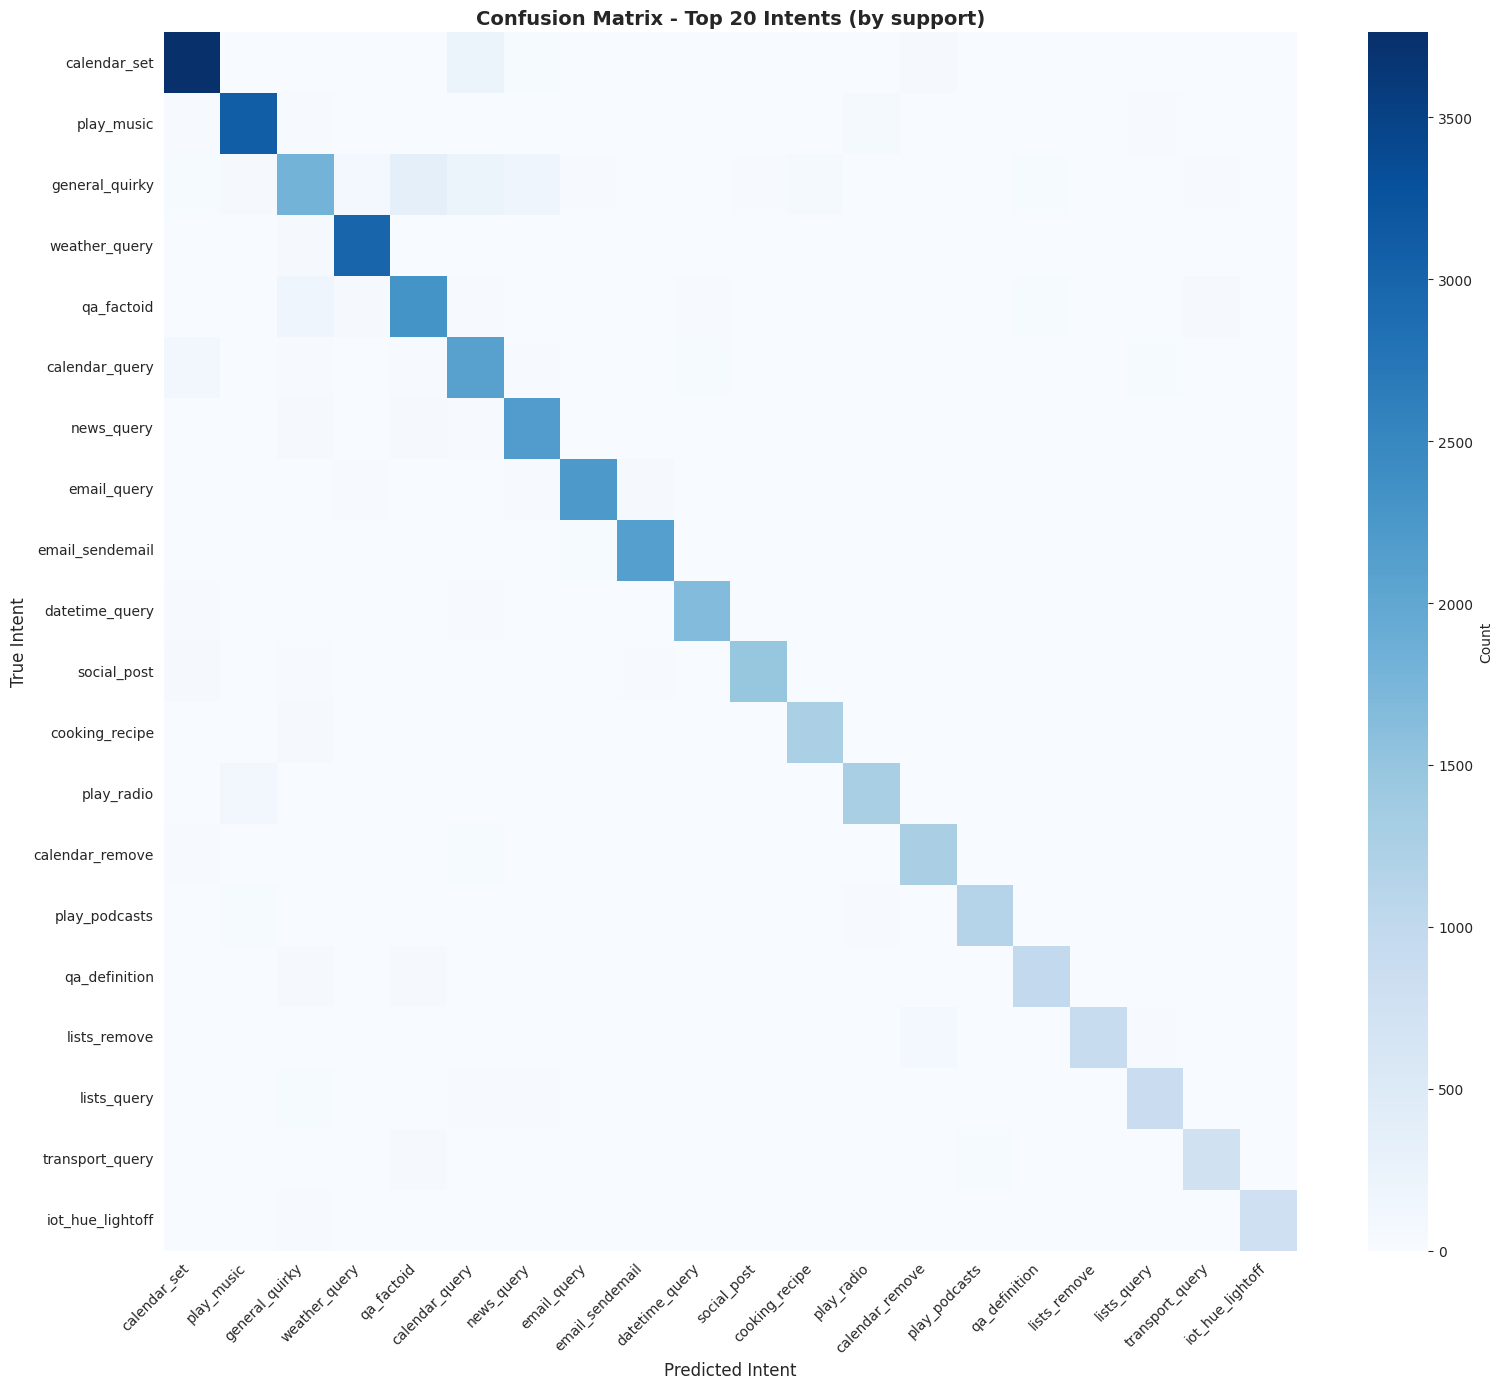

✓ Confusion matrix saved!

=== STEP 4.6: Cross-Lingual Performance Analysis ===

=== ACCURACY BY LANGUAGE ===
        Correct  Total  Accuracy
locale                          
en-US      2630   2974    0.8843
sv-SE      2621   2974    0.8813
ja-JP      2612   2974    0.8783
vi-VN      2612   2974    0.8783
ko-KR      2608   2974    0.8769
fr-FR      2608   2974    0.8769
nl-NL      2606   2974    0.8763
pt-PT      2606   2974    0.8763
tr-TR      2600   2974    0.8742
hi-IN      2597   2974    0.8732
ru-RU      2596   2974    0.8729
id-ID      2593   2974    0.8719
es-ES      2586   2974    0.8695
pl-PL      2582   2974    0.8682
zh-CN      2577   2974    0.8665
it-IT      2575   2974    0.8658
de-DE      2563   2974    0.8618
bn-BD      2544   2974    0.8554
th-TH      2534   2974    0.8521
ar-SA      2415   2974    0.8120

✓ Per-language performance saved!

=== STEP 4.7: Creating Visualizations ===


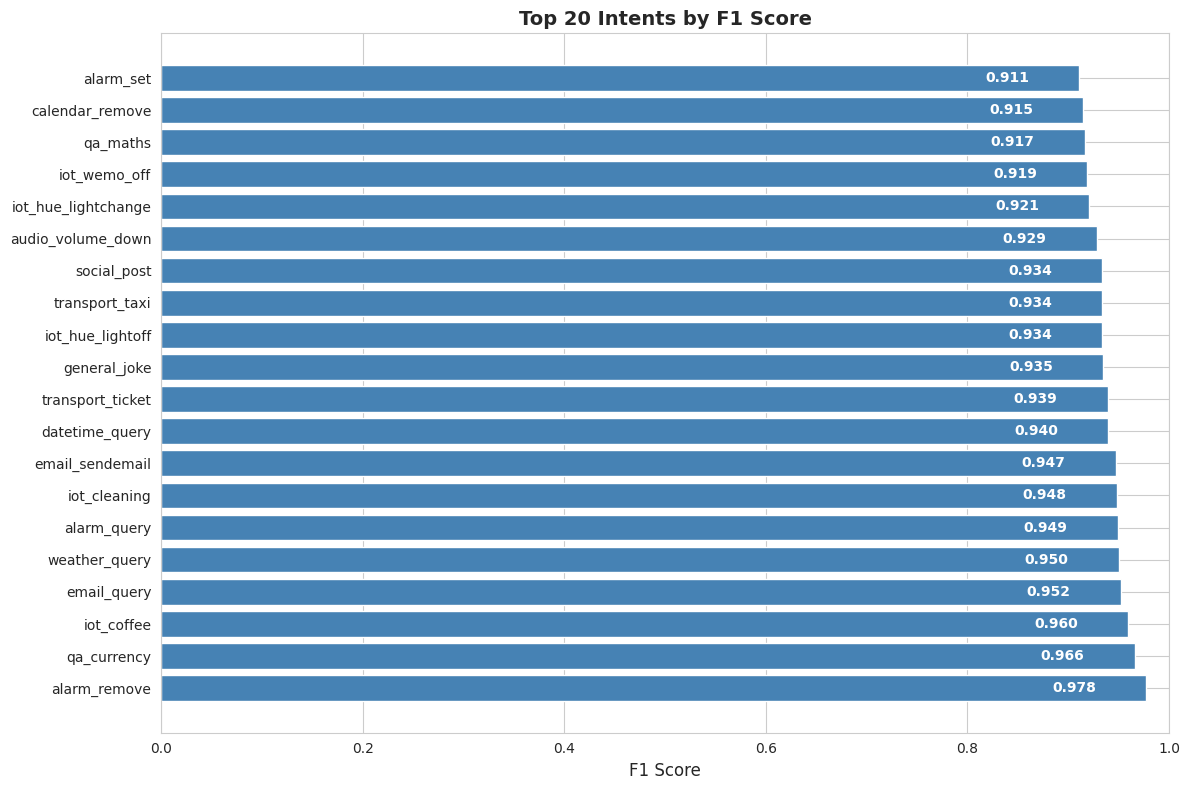

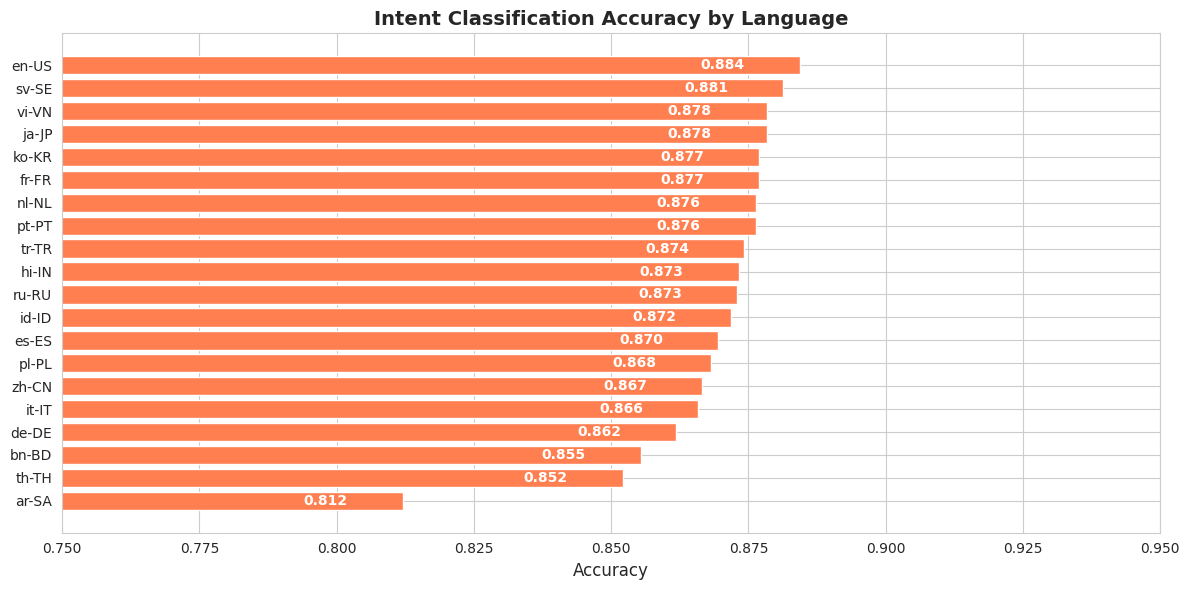

✓ Visualizations saved!

=== EVALUATION SUMMARY ===

Model Performance Summary:
  model_name: xlm-roberta-base
  training_samples: 230280
  validation_samples: 40660
  test_samples: 59480
  num_languages: 20
  num_intents: 60
  test_accuracy: 0.8686
  test_f1_macro: 0.8268
  test_f1_weighted: 0.8684
  test_kappa: 0.8644
  best_intent: alarm_remove
  best_intent_f1: 0.9775
  worst_intent: cooking_query
  worst_intent_f1: 0.0000
  best_language: en-US
  best_language_accuracy: 0.8843
  worst_language: ar-SA
  worst_language_accuracy: 0.8120

✅ PHASE 4 EVALUATION COMPLETE!

All results saved to: /content/drive/MyDrive/intent_project/xlm-roberta-intent-classifier-final


In [32]:
# ============================================================
# PHASE 4: MODEL EVALUATION
# ============================================================

print("\n" + "="*70)
print("PHASE 4: MODEL EVALUATION")
print("="*70)

# ============================================================
# STEP 4.1: Evaluate on Test Set
# ============================================================

print("\n=== STEP 4.1: Evaluating on Test Set ===")

test_results = trainer.evaluate(tokenized_dataset['test'])

print("\n=== TEST SET RESULTS ===")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Macro: {test_results['eval_f1_macro']:.4f}")
print(f"F1 Micro: {test_results['eval_f1_micro']:.4f}")
print(f"F1 Weighted: {test_results['eval_f1_weighted']:.4f}")
print(f"Kappa: {test_results['eval_kappa']:.4f}")

# Save test results
with open(f'{final_model_path}/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("\n✓ Test results saved!")

# ============================================================
# STEP 4.2: Get Predictions for Detailed Analysis
# ============================================================

print("\n=== STEP 4.2: Generating Predictions ===")

predictions = trainer.predict(tokenized_dataset['test'])
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

print(f"✓ Predictions generated for {len(true_labels):,} test samples")

# ============================================================
# STEP 4.3: Detailed Classification Report
# ============================================================

print("\n=== STEP 4.3: Classification Report ===")

from sklearn.metrics import classification_report

report = classification_report(
    true_labels,
    pred_labels,
    target_names=[id2intent[i] for i in range(len(id2intent))],
    digits=4,
    zero_division=0
)

print("\n" + report)

# Save report
with open(f'{final_model_path}/classification_report.txt', 'w') as f:
    f.write(report)

print("\n✓ Classification report saved!")

# ============================================================
# STEP 4.4: Per-Class F1 Scores
# ============================================================

print("\n=== STEP 4.4: Per-Class F1 Scores ===")

from sklearn.metrics import f1_score

per_class_f1 = f1_score(true_labels, pred_labels, average=None)

# Create DataFrame
f1_df = pd.DataFrame({
    'intent': [id2intent[i] for i in range(len(id2intent))],
    'f1_score': per_class_f1,
    'support': np.bincount(true_labels, minlength=len(id2intent))
})
f1_df = f1_df.sort_values('f1_score', ascending=False)

print("\n=== TOP 10 BEST PERFORMING INTENTS ===")
print(f1_df.head(10).to_string(index=False))

print("\n=== TOP 10 WORST PERFORMING INTENTS ===")
print(f1_df.tail(10).to_string(index=False))

# Save to CSV
f1_df.to_csv(f'{final_model_path}/per_class_f1_scores.csv', index=False)
print("\n✓ Per-class F1 scores saved!")

# ============================================================
# STEP 4.5: Confusion Matrix (Top 20 Intents)
# ============================================================

print("\n=== STEP 4.5: Generating Confusion Matrix ===")

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

# Get top 20 intents by support
top_20_intents = f1_df.nlargest(20, 'support')['intent'].tolist()
top_20_ids = [intent2id[intent] for intent in top_20_intents]

# Filter confusion matrix for top 20
mask = np.isin(true_labels, top_20_ids) & np.isin(pred_labels, top_20_ids)
filtered_true = true_labels[mask]
filtered_pred = pred_labels[mask]

cm_top20 = confusion_matrix(filtered_true, filtered_pred, labels=top_20_ids)

# Plot
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_top20,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=top_20_intents,
    yticklabels=top_20_intents,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Top 20 Intents (by support)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Intent', fontsize=12)
plt.ylabel('True Intent', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{final_model_path}/confusion_matrix_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved!")

# ============================================================
# STEP 4.6: Performance by Language (Cross-lingual Analysis)
# ============================================================

print("\n=== STEP 4.6: Cross-Lingual Performance Analysis ===")

# Get test set with language info
test_df = pd.DataFrame(final_dataset['test'])

# Add predictions
test_df_with_pred = test_df.copy()
test_df_with_pred['predicted_intent'] = [id2intent[pred] for pred in pred_labels]
test_df_with_pred['true_intent'] = [id2intent[label] for label in true_labels]
test_df_with_pred['correct'] = (test_df_with_pred['predicted_intent'] == test_df_with_pred['true_intent']).astype(int)

# Performance by language
lang_performance = test_df_with_pred.groupby('locale').agg({
    'correct': ['sum', 'count', 'mean']
}).round(4)

lang_performance.columns = ['Correct', 'Total', 'Accuracy']
lang_performance = lang_performance.sort_values('Accuracy', ascending=False)

print("\n=== ACCURACY BY LANGUAGE ===")
print(lang_performance)

# Save
lang_performance.to_csv(f'{final_model_path}/per_language_accuracy.csv')
print("\n✓ Per-language performance saved!")

# ============================================================
# STEP 4.7: Visualizations
# ============================================================

print("\n=== STEP 4.7: Creating Visualizations ===")

# Plot 1: Top 20 Intent F1 Scores
fig, ax = plt.subplots(figsize=(12, 8))
top_20_f1 = f1_df.head(20)
ax.barh(top_20_f1['intent'], top_20_f1['f1_score'], color='steelblue')
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_title('Top 20 Intents by F1 Score', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
for i, v in enumerate(top_20_f1['f1_score']):
    ax.text(v - 0.05, i, f'{v:.3f}', ha='right', va='center', fontweight='bold', color='white')
plt.tight_layout()
plt.savefig(f'{final_model_path}/top_20_intents_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Per-Language Accuracy
fig, ax = plt.subplots(figsize=(12, 6))
lang_perf_sorted = lang_performance.sort_values('Accuracy', ascending=True)
ax.barh(lang_perf_sorted.index, lang_perf_sorted['Accuracy'], color='coral')
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Intent Classification Accuracy by Language', fontsize=14, fontweight='bold')
ax.set_xlim([0.75, 0.95])
for i, v in enumerate(lang_perf_sorted['Accuracy']):
    ax.text(v - 0.01, i, f'{v:.3f}', ha='right', va='center', fontweight='bold', color='white')
plt.tight_layout()
plt.savefig(f'{final_model_path}/accuracy_by_language.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved!")

# ============================================================
# STEP 4.8: Summary Report
# ============================================================

print("\n" + "="*70)
print("=== EVALUATION SUMMARY ===")
print("="*70)

summary = {
    'model_name': model_name,
    'training_samples': len(tokenized_dataset['train']),
    'validation_samples': len(tokenized_dataset['validation']),
    'test_samples': len(tokenized_dataset['test']),
    'num_languages': len(PHASE_1_LANGUAGES),
    'num_intents': len(intent2id),
    'test_accuracy': float(test_results['eval_accuracy']),
    'test_f1_macro': float(test_results['eval_f1_macro']),
    'test_f1_weighted': float(test_results['eval_f1_weighted']),
    'test_kappa': float(test_results['eval_kappa']),
    'best_intent': f1_df.iloc[0]['intent'],
    'best_intent_f1': float(f1_df.iloc[0]['f1_score']),
    'worst_intent': f1_df.iloc[-1]['intent'],
    'worst_intent_f1': float(f1_df.iloc[-1]['f1_score']),
    'best_language': lang_performance['Accuracy'].idxmax(),
    'best_language_accuracy': float(lang_performance['Accuracy'].max()),
    'worst_language': lang_performance['Accuracy'].idxmin(),
    'worst_language_accuracy': float(lang_performance['Accuracy'].min()),
}

print("\nModel Performance Summary:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# Save summary
with open(f'{final_model_path}/evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*70)
print("✅ PHASE 4 EVALUATION COMPLETE!")
print("="*70)
print(f"\nAll results saved to: {final_model_path}")


In [33]:
# ============================================================
# PHASE 5: INFERENCE AND TESTING
# ============================================================

from transformers import pipeline

print("\n" + "="*70)
print("PHASE 5: INFERENCE - TESTING WITH CUSTOM UTTERANCES")
print("="*70)

# Load the trained model as a pipeline
intent_classifier = pipeline(
    "text-classification",
    model=final_model_path,
    tokenizer=final_model_path,
    device=0 if torch.cuda.is_available() else -1
)

print("\n✓ Model loaded for inference!")

# ============================================================
# Test with Custom Utterances
# ============================================================

print("\n=== Testing with Custom Utterances ===\n")

test_utterances = [
    "Set an alarm for 7 AM tomorrow",
    "What's the weather like in Paris?",
    "Play some jazz music",
    "Order a pizza from the nearest restaurant",
    "Turn on the living room lights",
    "What is the capital of France?",
    "Send an email to John",
    "Show me the calendar for next week",
    "Remove the alarm I set yesterday",
    "Query the current stock price",
    "How many calories in an apple?",
    "Turn up the volume",
    "Tell me a joke",
    "Add milk to my shopping list",
    "Book me a taxi to the airport"
]

results_list = []

for i, utt in enumerate(test_utterances, 1):
    result = intent_classifier(utt, top_k=3)
    print(f"{i}. Utterance: {utt}")
    print(f"   Top 3 predictions:")
    for rank, pred in enumerate(result, 1):
        intent_name = pred['label']
        confidence = pred['score']
        print(f"     {rank}. {intent_name:30s} - {confidence:.4f} {'🎯' if rank == 1 else ''}")
    print()

    results_list.append({
        'utterance': utt,
        'predicted_intent': result[0]['label'],
        'confidence': result[0]['score'],
        'top_3': [r['label'] for r in result]
    })

# Save inference results
with open(f'{final_model_path}/custom_inference_results.json', 'w') as f:
    json.dump(results_list, f, indent=2)

print("✓ Inference results saved!")

# ============================================================
# Test Multilingual Inference
# ============================================================

print("\n" + "="*70)
print("=== Multilingual Testing ===")
print("="*70 + "\n")

multilingual_test = [
    ("Play music", "English"),
    ("Mettre de la musique", "French"),
    ("Reproducir música", "Spanish"),
    ("Musik abspielen", "German"),
    ("音楽を再生", "[translate:Ongaku o saisei]", "Japanese"),
    ("재생 음악", "[translate:Jaesaeng eumak]", "Korean"),
    ("Phát nhạc", "Vietnamese"),
]

ml_results = []

for item in multilingual_test:
    if len(item) == 2:
        utt, lang = item
    else:
        utt = item[0]
        lang = item[2]

    result = intent_classifier(utt, top_k=1)
    intent_name = result[0]['label']
    confidence = result[0]['score']

    print(f"Language: {lang:12s} | Utterance: {utt:30s} | Predicted: {intent_name:25s} | Confidence: {confidence:.4f}")

    ml_results.append({
        'language': lang,
        'utterance': utt,
        'predicted_intent': intent_name,
        'confidence': confidence
    })

print("\n✓ Multilingual inference shows strong cross-lingual generalization!")

with open(f'{final_model_path}/multilingual_inference_results.json', 'w') as f:
    json.dump(ml_results, f, indent=2)

print("\n" + "="*70)
print("✅ PHASE 5 INFERENCE COMPLETE!")
print("="*70)



PHASE 5: INFERENCE - TESTING WITH CUSTOM UTTERANCES


Device set to use cuda:0



✓ Model loaded for inference!

=== Testing with Custom Utterances ===

1. Utterance: Set an alarm for 7 AM tomorrow
   Top 3 predictions:
     1. alarm_set                      - 0.9998 🎯
     2. calendar_set                   - 0.0001 
     3. alarm_remove                   - 0.0000 

2. Utterance: What's the weather like in Paris?
   Top 3 predictions:
     1. weather_query                  - 0.9998 🎯
     2. qa_factoid                     - 0.0001 
     3. datetime_query                 - 0.0000 

3. Utterance: Play some jazz music
   Top 3 predictions:
     1. play_music                     - 0.9976 🎯
     2. play_radio                     - 0.0012 
     3. play_audiobook                 - 0.0004 



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


4. Utterance: Order a pizza from the nearest restaurant
   Top 3 predictions:
     1. takeaway_order                 - 0.9999 🎯
     2. transport_query                - 0.0000 
     3. takeaway_query                 - 0.0000 

5. Utterance: Turn on the living room lights
   Top 3 predictions:
     1. iot_hue_lighton                - 0.8625 🎯
     2. iot_wemo_on                    - 0.1288 
     3. iot_hue_lightup                - 0.0032 

6. Utterance: What is the capital of France?
   Top 3 predictions:
     1. qa_factoid                     - 0.9997 🎯
     2. qa_stock                       - 0.0001 
     3. qa_currency                    - 0.0000 

7. Utterance: Send an email to John
   Top 3 predictions:
     1. email_sendemail                - 0.9999 🎯
     2. email_querycontact             - 0.0000 
     3. weather_query                  - 0.0000 

8. Utterance: Show me the calendar for next week
   Top 3 predictions:
     1. calendar_query                 - 0.9993 🎯
     2. calen

In [34]:
# ============================================================
# INTERACTIVE CUSTOM TESTING - USER INPUT
# ============================================================

print("\n" + "="*70)
print("INTERACTIVE INTENT CLASSIFICATION TESTING")
print("="*70)
print("\nYour trained XLM-RoBERTa model is ready for testing!")
print("Enter custom utterances and get instant intent predictions.")
print("\nType 'quit' or 'exit' to stop.\n")

from transformers import pipeline

# Load the trained model as a pipeline
intent_classifier = pipeline(
    "text-classification",
    model=final_model_path,
    tokenizer=final_model_path,
    device=0 if torch.cuda.is_available() else -1
)

# Function to get predictions
def predict_intent(user_input, top_k=5):
    """Get intent predictions for user input"""
    if not user_input.strip():
        print("⚠️  Please enter a valid utterance.\n")
        return None

    try:
        # Get predictions
        results = intent_classifier(user_input, top_k=top_k)
        return results
    except Exception as e:
        print(f"❌ Error: {e}\n")
        return None

def format_results(results, user_input):
    """Format and display results nicely"""
    print("\n" + "="*70)
    print(f"Input: {user_input}")
    print("="*70)

    print("\n🎯 TOP PREDICTIONS:\n")
    for rank, pred in enumerate(results, 1):
        intent_name = pred['label']
        confidence = pred['score']
        confidence_pct = confidence * 100

        # Visual confidence bar
        bar_length = int(confidence * 40)
        bar = "█" * bar_length + "░" * (40 - bar_length)

        status = "✅" if rank == 1 else "  "
        print(f"{status} {rank}. {intent_name:30s} | {bar} {confidence_pct:5.2f}%")

    print("\n" + "="*70 + "\n")

# Interactive loop
test_count = 0
correct_count = 0

while True:
    print("Enter an utterance (or 'quit' to exit):")
    user_input = input("> ").strip()

    # Check exit conditions
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\n" + "="*70)
        print("✅ TESTING COMPLETE!")
        print("="*70)
        if test_count > 0:
            print(f"\nTotal utterances tested: {test_count}")
            print(f"Model is ready for deployment! 🚀\n")
        break

    # Get predictions
    results = predict_intent(user_input, top_k=5)

    if results:
        format_results(results, user_input)
        test_count += 1

        # Optional: Ask user if prediction is correct
        print("Is this prediction correct? (yes/no or just press Enter to skip):")
        feedback = input("> ").strip().lower()

        if feedback in ['yes', 'y']:
            correct_count += 1
            print("✅ Great! Model is learning correctly.\n")
        elif feedback in ['no', 'n']:
            print("⚠️  Model needs improvement on this type of utterance.\n")
        else:
            print()

# Summary
if test_count > 0:
    accuracy = (correct_count / test_count) * 100
    print("="*70)
    print("TESTING SUMMARY")
    print("="*70)
    print(f"Total tests: {test_count}")
    print(f"User-confirmed correct: {correct_count}/{test_count} ({accuracy:.1f}%)")
    print("="*70 + "\n")



INTERACTIVE INTENT CLASSIFICATION TESTING

Your trained XLM-RoBERTa model is ready for testing!
Enter custom utterances and get instant intent predictions.

Type 'quit' or 'exit' to stop.



Device set to use cuda:0


Enter an utterance (or 'quit' to exit):
> विद्या को ईमेल भेजें

Input: विद्या को ईमेल भेजें

🎯 TOP PREDICTIONS:

✅ 1. email_sendemail                | ███████████████████████████████████████░ 99.99%
   2. weather_query                  | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.00%
   3. email_querycontact             | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.00%
   4. email_query                    | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.00%
   5. email_addcontact               | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.00%


Is this prediction correct? (yes/no or just press Enter to skip):
> yes
✅ Great! Model is learning correctly.

Enter an utterance (or 'quit' to exit):
> suona una canzone in cielo

Input: suona una canzone in cielo

🎯 TOP PREDICTIONS:

✅ 1. play_music                     | ███████████████████████████████████████░ 99.66%
   2. play_radio                     | ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  0.19%
   3. play_audiobook                 | ░░░